# GradientBoostingRegressor
Haytham Mohamed

INFS 890 - Spring 2020

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [218]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True
SCALE_FEATURES = True

FEATURES_SELECTION = True

test_split = 0.2

In [219]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [220]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)

print('data shape {}'.format(data.shape))

data.head(5)

data shape (6766, 29)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
0,0.0300,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0700,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,2.5000,1.6700,2.7617,0.1500,0.2400
1,0.0600,0.0200,0.0200,0.0200,0.0200,0.0100,0.0100,0.1800,0.1800,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,1.8900,1.0100,2.7617,0.1500,0.2400
2,0.0700,0.0300,0.0200,0.0300,0.0200,0.0100,0.0100,0.4400,0.2000,1.0000,...,16.0739,13.5708,16.9964,27.3438,16.6522,1.3500,0.0500,2.5880,0.1500,0.2400
3,0.0700,0.0300,0.0200,0.0200,0.0200,0.0100,0.0100,0.2300,0.1700,1.0000,...,19.9869,14.4342,9.5804,9.4313,17.1768,1.2600,0.0400,2.1487,0.1300,0.2400
4,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.2400,0.1400,1.0000,...,10.4490,3.7392,2.7970,9.1791,6.2516,1.2800,0.2600,1.8080,0.3600,0.2400


In [221]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 28 features


In [222]:
# print out the features
for feature in inputs.columns.values:
    print(feature)

front-end_cpu_use
orders_cpu_use
orders-db_cpu_use
user_cpu_use
user-db_cpu_use
shipping_cpu_use
payment_cpu_use
carts_cpu_use
carts-db_cpu_use
front-end_pods
orders_pods
user_pods
shipping_pods
payment_pods
carts_pods
front-end_net_use
orders_net_use
orders-db_net_use
user_net_use
user-db_net_use
shipping_net_use
payment_net_use
carts_net_use
carts-db_net_use
nodes_cpu_use
nodes_disk_io
nodes_net_use
orders_req


# Features Selection

In [223]:
def features_selection(x, y, to_scale=FEATURES_SELECTION):
    if to_scale:  
        #clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)    
        clf = LassoCV(tol=0.1)
        sfm = SelectFromModel(clf, threshold='0.05*mean')

        selectedFeatures = sfm.fit(x, y).transform(x)
        print('{} features selected'.format(selectedFeatures[1].shape[0]))
        
        feature_list = x.columns[sfm.get_support()]
        features = ''
        features = ', '.join(feature_list)
    
        print("columns selected are {}".format(features))

        x = x[feature_list]        
    return x


In [224]:
inputs = features_selection(inputs, targets)

12 features selected
columns selected are carts_cpu_use, carts-db_cpu_use, front-end_pods, orders_net_use, orders-db_net_use, user_net_use, shipping_net_use, payment_net_use, carts_net_use, nodes_cpu_use, nodes_net_use, orders_req


In [225]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))
    
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)  

if SCALE_FEATURES:
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)

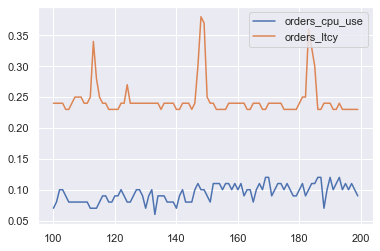

In [226]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()


# Model

In [227]:

reg = GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, random_state=100, n_iter_no_change=3, max_depth=60)


In [228]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

reg.fit(x_train, y_train)

sklearn version 0.22.2.post1


/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=60, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=3, presort='deprecated',
                          random_state=100, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Training R2

In [229]:
y_train_pred = reg.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_pred)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(reg.score(x_train,y_train)))

R2 (training) = 0.9096658172532055
Score (training) = 0.9096658172532056


In [230]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_pred)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.36 (0.30) 0.00 0.96 MSE


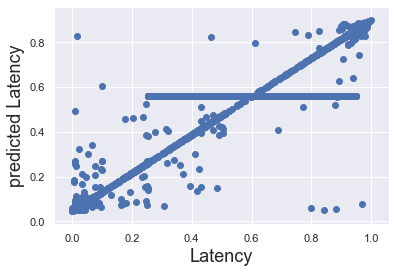

In [231]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

# Testing

In [232]:
y_test_pred = reg.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

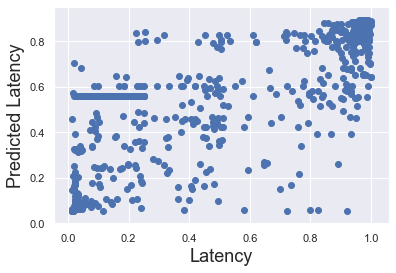

In [233]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

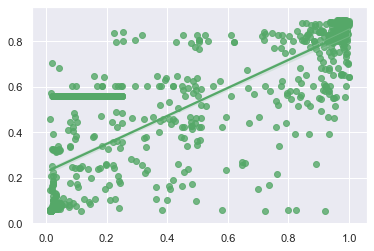

In [234]:
ax = sns.regplot(x=y_test, y=y_test_pred, color='g')

In [235]:
perf = pd.DataFrame(y_test_pred, columns=['prediction'])
perf['target'] = y_test
perf.head()

,prediction,target
0,0.5586,0.2517
1,0.5586,0.2510
2,0.5586,0.2504
3,0.5586,0.2497
4,0.5586,0.2491


In [236]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,0.5586,0.2517,0.3069,121.9326
1,0.5586,0.2510,0.3076,122.5079
2,0.5586,0.2504,0.3082,123.0862
3,0.5586,0.2497,0.3089,123.6676
4,0.5586,0.2491,0.3095,124.2520
...,...,...,...,...
1349,0.8914,0.9877,-0.0962,9.7420
1350,0.8737,0.9877,-0.1140,11.5374
1351,0.8421,0.9856,-0.1435,14.5595
1352,0.6019,0.9887,-0.3868,39.1235


In [237]:
perf.describe()

,prediction,target,residual,difference%
count,"1,354.0000","1,354.0000","1,354.0000","1,354.0000"
mean,0.4071,0.2942,0.1129,257.4222
std,0.2959,0.3593,0.2408,411.9889
min,0.0534,0.0134,-0.8657,0.3523
25%,0.0682,0.0236,-0.0134,35.0551
50%,0.5586,0.1062,0.0426,181.7585
75%,0.5586,0.4838,0.3438,235.2816
max,0.8934,1.0000,0.6840,"3,502.6949"


In [238]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.4f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
1233,0.8715,0.8746,-0.0031,0.3523
1276,0.7711,0.7739,-0.0028,0.3600
919,0.2814,0.2795,0.0019,0.6755
1235,0.8773,0.8869,-0.0097,1.0887
938,0.4673,0.4738,-0.0065,1.3717
...,...,...,...,...
374,0.5586,0.0216,0.5370,2488.1609
1204,0.5593,0.0185,0.5408,2923.3954
1104,0.4576,0.0144,0.4432,3080.5715
1225,0.5709,0.0164,0.5545,3372.0672


# *** Prediction Accuracy

In [239]:
r2_test = metrics.r2_score(y_test, y_test_pred)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.4517931482544849


In [240]:
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.265916123987842
